# Imports

In [4]:
from data_classes import LAQNData, HealthData, MetData
from os import path
import pandas as pd
import matplotlib.pyplot as plt

# Load data

### Load the hourly NO$_2$ data

In [5]:
data_folder = path.join(path.abspath(""), "LAQN_data")
species = "NO2"
url = "http://api.erg.kcl.ac.uk/AirQuality/Information/MonitoringSites/GroupName=London/Json"
start_date = "2000-01-01"
end_date = "2021-01-01"

In [6]:
NO2_hourly = LAQNData(url, data_folder, species, start_date, end_date)

In [7]:
hourly_NO2_df = NO2_hourly.read_csv(index_col="date")
print(hourly_NO2_df.shape)

Reading NO2_hourly_2000-01-01_2021-01-01.csv...
(184105, 192)


### Load the hourly meteorology data

In [8]:
data_folder = path.join(path.abspath(""), "met_data")
url = "https://bulk.meteostat.net/hourly/03772.csv.gz"

In [9]:
heathrow = MetData(data_folder, url=url)

In [10]:
hourly_met_df = heathrow.read_csv()
print(hourly_met_df.shape)

Reading hourly_heathrow_met_data.csv...
(510165, 8)


### Load the daily mortality per capita data

In [11]:
data_folder = path.join(path.abspath(""), "mortality_data/daily")
filename = "daily_mortality_percapita_London.csv"

In [12]:
mortality_daily = HealthData(data_folder, filename=filename)

In [67]:
mortality_df = pd.DataFrame(mortality_daily.read_csv(index_col="date"))
print(mortality_df.shape)

Reading daily_mortality_percapita_London.csv...
(13698, 3)


In [69]:
mortality_df["deaths_per_100k"] = mortality_df["deaths_per_capita"]*100000

# Process data + plots

## Daily data

In [14]:
daily_dates = mortality_df.index

### Resample the hourly NO$_2$ data using a custom date list

Only retain the NO$_2$ data up to the final mortality datapoint:

In [15]:
hourly_NO2_df = hourly_NO2_df.loc[hourly_NO2_df.index < daily_dates.max()]

In [16]:
daily_NO2_df = hourly_NO2_df.groupby(daily_dates[daily_dates.searchsorted(hourly_NO2_df.index)]).mean()

We've now generated a dataframe of weekly mean NO$_2$ concentrations (from the hourly data) using the weekly dates given by the mortality dataset. 
- The `searchsorted()` function takes the `hourly_df` index and inserts it into `weekly_dates` to return an array of indices where the hourly elements should be inserted to maintain order in the weekly dates. See docs [here](https://pandas.pydata.org/pandas-docs/version/0.21.1/generated/pandas.DatetimeIndex.searchsorted.html).
- Placing these indices inside `weekly_dates[]` produces an array the same length as the hourly index, where each entry is the corresponding "weekly" date.
- The `groupby()` operation then performs the `mean()` function on the hourly data, grouping by the assigned weekly dates in the previous step. See docs [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html).

In [17]:
daily_NO2_df.shape

(6940, 192)

### Spatially average the NO$_2$ data for all of London

In [70]:
NO2_df = pd.DataFrame(daily_NO2_df.mean(axis=1), columns=["mean_NO2"]).join(mortality_df)

In [71]:
NO2_df.head()

,mean_NO2,total_population,deaths,deaths_per_capita,deaths_per_100k
date,,,,,
2000-01-01,44.654545,7.195538e+06,327,0.000045,4.544483
2000-01-02,52.885482,7.195764e+06,291,0.000040,4.044046
2000-01-03,42.606277,7.195991e+06,312,0.000043,4.335748
2000-01-04,36.740944,7.196217e+06,288,0.000040,4.002103
2000-01-05,64.076266,7.196443e+06,305,0.000042,4.238205


#### Scatter plot mortality vs NO$_2$

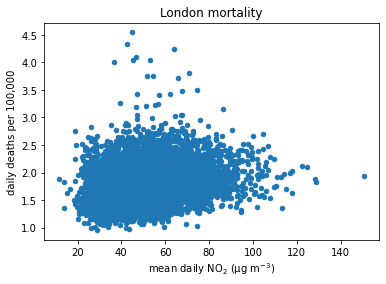

In [17]:
NO2_df.plot.scatter(x="mean_NO2", y="deaths_per_100k", legend=False, title="London mortality").set_ylabel("daily deaths per 100,000")
plt.xlabel("mean daily NO$_2$ (µg m$^{-3}$)")
plt.show()

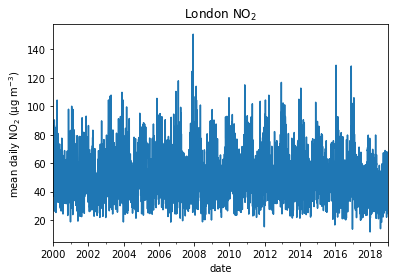

In [18]:
NO2_df.plot(y="mean_NO2", legend=False, title="London NO$_2$").set_ylabel("mean daily NO$_2$ (µg m$^{-3}$)")
plt.show()

### Resample the hourly meteorology data using a custom date list

Only retain the met data up to the final mortality datapoint:

In [20]:
hourly_met_df = hourly_met_df.loc[hourly_met_df.index < daily_dates.max()]

In [21]:
daily_met_df = hourly_met_df.groupby(daily_dates[daily_dates.searchsorted(hourly_met_df.index)]).mean()

In [22]:
daily_met_df.shape

(13695, 8)

In [24]:
daily_met_df.columns

Index(['temperature', 'dew_point', 'humidity', 'precip', 'wind_dir',
       'wind_speed', 'peak_gust', 'pressure'],
      dtype='object')

In [72]:
temperature_df = pd.DataFrame(daily_met_df["temperature"]).join(mortality_df)

In [73]:
temperature_df.columns

Index(['temperature', 'total_population', 'deaths', 'deaths_per_capita',
       'deaths_per_100k'],
      dtype='object')

#### Scatter plot of mortality vs temperature

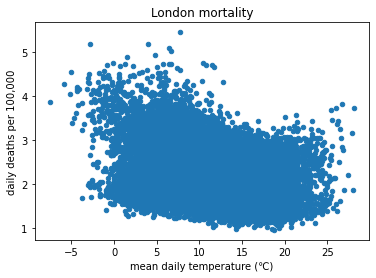

In [25]:
temperature_df.plot.scatter(x="temperature", y="deaths_per_100k", legend=False, title="London mortality").set_ylabel("daily deaths per 100,000")
plt.xlabel("mean daily temperature (℃)")
plt.show()

### Scatter plot of NO$_2$ vs temperature

#### Daily averages

In [27]:
daily_df = pd.DataFrame(NO2_df["mean_NO2"]).join(temperature_df)

In [28]:
daily_df.columns

Index(['mean_NO2', 'temperature', 'total_population', 'deaths',
       'deaths_per_capita', 'deaths_per_100k'],
      dtype='object')

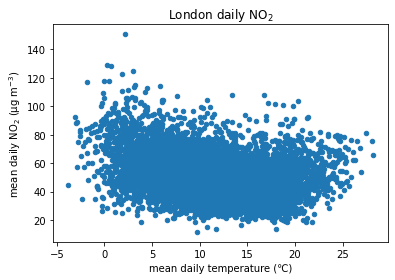

In [37]:
daily_df.plot.scatter(x="temperature", y="mean_NO2", legend=False, title="London daily NO$_2$").set_ylabel("mean daily NO$_2$ (µg m$^{-3}$)")
plt.xlabel("mean daily temperature (℃)")
plt.show()

#### Hourly averages

In [29]:
hourly_met_df.shape

(489688, 8)

In [30]:
hourly_NO2_df.shape

(166536, 192)

In [31]:
hourly_df = hourly_met_df.join(pd.DataFrame(hourly_NO2_df.mean(axis=1), columns=["mean_NO2"]))

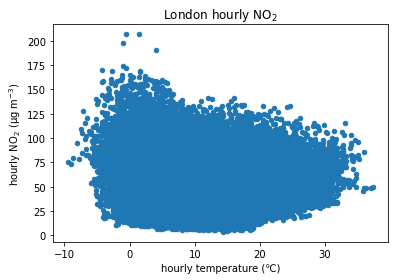

In [50]:
hourly_df.plot.scatter(x="temperature", y="mean_NO2", legend=False, title="London hourly NO$_2$").set_ylabel("hourly NO$_2$ (µg m$^{-3}$)")
plt.xlabel("hourly temperature (℃)")
plt.show()

## Time series decomposition: trends

**Trends** represent how the variable is changing overall through time.
**Seasonality** shows how the variable changes within a given period e.g. year, month.
**Residual** activity is not explained by the trend or seasonality.

Additive model: 
`y(t) = Trend(t) + Seasonality(t) + Residual(t)`

Multiplicative model:
`y(t) = Trend(t) * Seasonality(t) * Residual(t)`

In [32]:
from statsmodels.api import tsa

Here we use the `seasonal_decompose()` function with an additive model. Note that we have to manually set `period` (for filtering) to `365`, because otherwise the function by default looks for weekly (`period=7`) trends when given daily data (inferred from the `DatetimeIndex`).

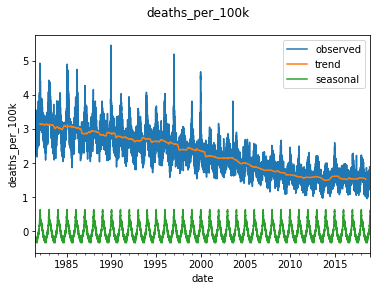

In [127]:
var = "deaths_per_100k"
decomp = tsa.seasonal_decompose(mortality_df[var], model="additive", period=365)
decomp_df = pd.DataFrame({"observed":decomp.observed, "trend":decomp.trend, "seasonal":decomp.seasonal, "residual":decomp.resid})

decomp_df["observed"].plot()
decomp_df["trend"].plot()
decomp_df["seasonal"].plot()
plt.legend()
plt.ylabel(var)
plt.suptitle(var)
plt.show()

# decomp_df.loc[decomp_df.index.year>2015]["seasonal"].plot()
# plt.show()

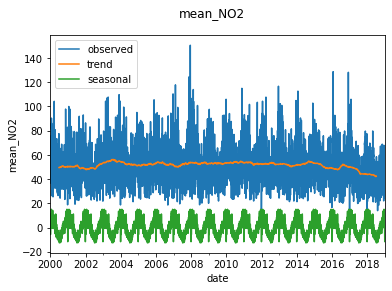

In [128]:
var = "mean_NO2"
decomp = tsa.seasonal_decompose(daily_df[var], model="additive", period=365)
decomp_df = pd.DataFrame({"observed":decomp.observed, "trend":decomp.trend, "seasonal":decomp.seasonal, "residual":decomp.resid})
decomp_df["observed"].plot()
decomp_df["trend"].plot()
decomp_df["seasonal"].plot()
plt.legend()
plt.ylabel(var)
plt.suptitle(var)
plt.show()

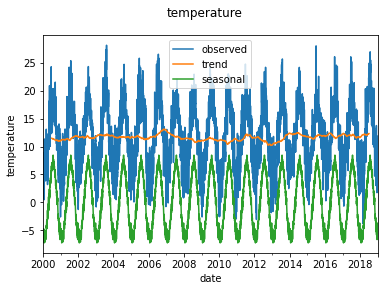

In [129]:
var = "temperature"
decomp = tsa.seasonal_decompose(daily_df[var], model="additive", period=365)
decomp_df = pd.DataFrame({"observed":decomp.observed, "trend":decomp.trend, "seasonal":decomp.seasonal, "residual":decomp.resid})
decomp_df["observed"].plot()
decomp_df["trend"].plot()
decomp_df["seasonal"].plot()
plt.legend()
plt.ylabel(var)
plt.suptitle(var)
plt.show()